# Improved models: Random Forest

In [38]:
import pandas as pd
import numpy as np
import os

from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import optuna
from functools import partial

import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

Figure prettifying

In [47]:
mpl.rcParams.update({
    'figure.autolayout': True,
    'figure.dpi': 150
})
sns.set()

## Data pre-processing

In [4]:
DATA_PATH = '../../data/raw'
X_train = pd.read_csv(
    os.path.join(DATA_PATH, 'training_set_features.csv')
).drop('respondent_id',axis =1)

X_test = pd.read_csv(
    os.path.join(DATA_PATH, 'test_set_features.csv')
).drop('respondent_id',axis =1)

y_train = pd.read_csv(
    os.path.join(DATA_PATH, 'training_set_labels.csv')
).drop('respondent_id',axis =1)

sub = pd.read_csv(os.path.join(DATA_PATH, 'submission_format.csv'))

## Models

Common preprocessor

In [5]:
num_features = X_train.columns[X_train.dtypes != "object"].values
cat_features = X_train.columns[X_train.dtypes == "object"].values

num_transformer = Pipeline([
    ('scale', StandardScaler()),
    ('impute', KNNImputer(n_neighbors = 10))
])

cat_transformer = Pipeline([
    ('impute', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
    ('encode', OneHotEncoder(drop = 'first'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

### Random forest

As the hyperparameter space is more complex for the random forest 
(at least 4 hyperparameters to examine, vs just $C$ for logistic regression)
we'll use Bayesian optimization with `optuna` to find suitable hyperparameters.

In [13]:
def objective_func(trial, X, y):
    
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'max_features': trial.suggest_uniform('max_features', 0.1, 1.0)
    }

    rf_model = Pipeline([
        ('pre', preprocessor),
        ('rf', MultiOutputClassifier(RandomForestClassifier(**params)))
    ])
    cv_score = cross_val_score(
        X = X,
        y = y,
        scoring = 'roc_auc',
        estimator = rf_model,
        cv = 5 # cannot use stratified k-fold in multilabel problems 
    )
    
    return np.mean(cv_score)

In [18]:
objective = partial(objective_func,X = X_train, y = y_train)
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 20)

[I 2020-07-20 15:49:34,231] Finished trial#0 with value: 0.8486900742211914 with parameters: {'criterion': 'gini', 'n_estimators': 1485, 'max_depth': 8, 'max_features': 0.802181010674788}. Best is trial#0 with value: 0.8486900742211914.
[I 2020-07-20 15:56:28,864] Finished trial#1 with value: 0.8471272611506308 with parameters: {'criterion': 'gini', 'n_estimators': 459, 'max_depth': 7, 'max_features': 0.6134950304471342}. Best is trial#0 with value: 0.8486900742211914.
[I 2020-07-20 16:02:20,683] Finished trial#2 with value: 0.8230106822084364 with parameters: {'criterion': 'entropy', 'n_estimators': 533, 'max_depth': 3, 'max_features': 0.71178696481428}. Best is trial#0 with value: 0.8486900742211914.
[I 2020-07-20 16:14:15,944] Finished trial#3 with value: 0.8509727074777633 with parameters: {'criterion': 'gini', 'n_estimators': 681, 'max_depth': 11, 'max_features': 0.623258071306126}. Best is trial#3 with value: 0.8509727074777633.
[I 2020-07-20 16:23:04,713] Finished trial#4 with v

Plt model performance over course of study

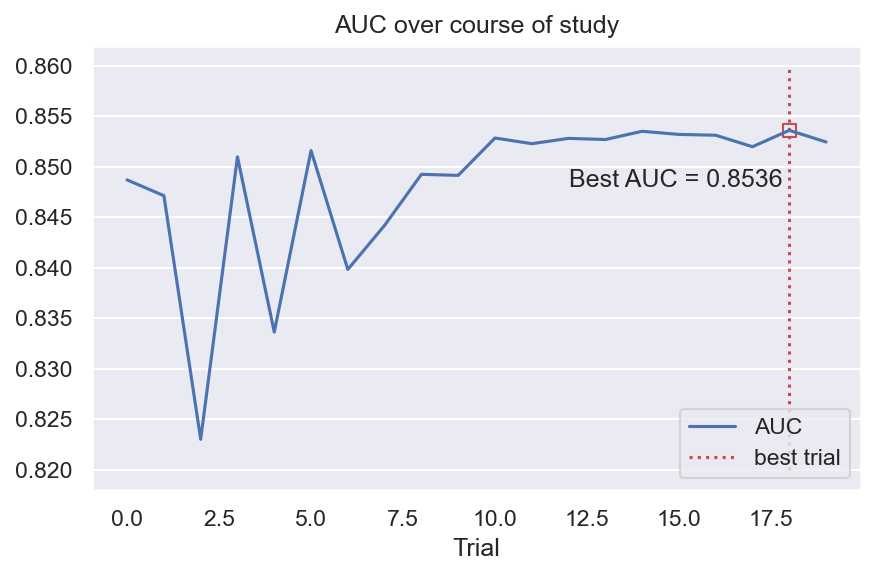

In [79]:
trials = study.get_trials()
trial_results = [trial.value for trial in trials]
indices = np.arange(0,20)

fig, ax = plt.subplots()
ax.plot(indices, trial_results)
ax.vlines(18, ymin = 0.82, ymax = 0.86,  colors = 'r', linestyle = 'dotted')
ax.scatter([18], [np.max(trial_results)], marker = 's', edgecolors = 'r', facecolors = 'none')
ax.annotate('Best AUC = {:.4f}'.format(max(trial_results)), xy = (12, 0.848))
ax.legend(['AUC', 'best trial'], loc = 'lower right')
ax.set_xlabel('Trial')
ax.grid(axis = 'x')
ax.set_title('AUC over course of study')
fig.savefig('../../results/figures/optuna_rf_performance.png')

In [80]:
params = study.best_params
params

{'criterion': 'gini',
 'n_estimators': 1231,
 'max_depth': 13,
 'max_features': 0.22345803642413833}

In [81]:
study.best_value

0.8536008740091761

This score is better than our previous CV score with logistic regression, 
so we build a submission using these parameters.

In [82]:
rf_model = Pipeline([
    ('pre', preprocessor),
    ('rf', MultiOutputClassifier(RandomForestClassifier(**params)))
])

rf_model.fit(X_train, y_train)
preds = rf_model.predict_proba(X_test)

In [86]:
sub['h1n1_vaccine'] = preds[0][:,1]
sub['seasonal_vaccine'] = preds[1][:,1]
sub.to_csv('../../results/predictions/tuned_rf_pred.csv', index = False)

Check for sanity

In [90]:
sub.head(10)

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.177618,0.286360
1,26708,0.028389,0.053237
2,26709,0.245901,0.708632
3,26710,0.622125,0.919212
4,26711,0.378361,0.612435
5,26712,0.680024,0.923546
6,26713,0.442812,0.593191
7,26714,0.120802,0.094889
8,26715,0.040188,0.078718
9,26716,0.145925,0.852485


## Results

0.8462 AUC, 133/953 leaderboard as of 20/07/2020